In [1]:
import time, torch, os, pickle
import tqdm
from rdkit.Chem import AllChem
from rdkit import Chem
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
from collections import defaultdict



radius_to_smiles_to_count = defaultdict(dict) # radius -> smiles -> [mol, count]


radius_for_generation = 9
split = "train"
file_names = os.listdir( f"/workspace/SMILES_dataset/{split}/HYUN_FP/")
path_dir = f"/workspace/SMILES_dataset/{split}/"
smiles_dict = pickle.load(open(f"{path_dir}/SMILES/index.pkl", "rb"))
name_dict = pickle.load(open(f"{path_dir}/Chemical/index.pkl", "rb"))

out_break = 0
for f in tqdm.tqdm(file_names[:10000]):
    idx = int(f.split(".")[0])
    smile = smiles_dict[idx]
    name = name_dict[idx]

    # Define a molecule
    mol = Chem.MolFromSmiles(smile)  
    mol_H = Chem.AddHs(mol) # add implicit Hs to the molecule


    # Generate the Morgan fingerprint with bit information
    
    info = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_H, radius=radius_for_generation, nBits=6144, bitInfo=info)

    counter_curr_mol = 0
    
    copied_info = dict(info)
    for bit_to_examine in list(info.keys()): 
        for atom_idx, radius in copied_info[bit_to_examine]:
            if radius<6: continue
            env = Chem.FindAtomEnvironmentOfRadiusN(mol_H, radius, atom_idx)
            amap = {}
            submol = Chem.PathToSubmol(mol_H, env, atomMap=amap)
            submol_smiles = Chem.MolToSmiles(submol)
            if submol_smiles not in radius_to_smiles_to_count[radius] :
                radius_to_smiles_to_count[radius][submol_smiles] = [submol, 1]
            else:
                radius_to_smiles_to_count[radius][submol_smiles][1] += 1
                
            # if submol_smiles in [ "", " "]:
                # print("empty smiles", f'radius is {radius}, bit is {bit_to_examine}, atom_idx is {atom_idx}, radius is {radius}')


100%|██████████| 10000/10000 [00:47<00:00, 209.05it/s]


In [2]:
def show_subgroup_of_radius(r=8, show_num=10):
    smiles_to_count = radius_to_smiles_to_count[r]
    sorted_smiles = sorted(smiles_to_count.items(), key=lambda x:x[1][1], reverse=True)
    for i, (smile, (mol, count)) in enumerate(sorted_smiles):
        if i>show_num: break
        print(f" smile : {smile}\ncount : {count}")
        display(Draw.MolToImage(mol))

In [3]:
# show_subgroup_of_radius()

In [4]:
# show_subgroup_of_radius(r=6, show_num=10)

In [12]:
'''
I  want to see if Radius-k is a subset of radius-(k+1)
'''

for f in tqdm.tqdm(file_names[:3]):
    idx = int(f.split(".")[0])
    smile = smiles_dict[idx]
    name = name_dict[idx]
    # Define a molecule
    mol = Chem.MolFromSmiles(smile)  
    mol_H = Chem.AddHs(mol) # add implicit Hs to the molecule
    
    print(f"SMILE : {smile}")

    for r in range(10):
    # Generate the Morgan fingerprint with bit information
        
        info = {}
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_H, radius=radius_for_generation, nBits=1024, bitInfo=info)
        curr_fp_bits = set(fp.GetOnBits())
        if r >0:
            print(last_fp_bits<=curr_fp_bits)
        last_fp_bits = curr_fp_bits
        

100%|██████████| 3/3 [00:00<00:00, 230.99it/s]

SMILE : C=C1C(=O)C23C(O)CC4C(C)(COC(C)=O)CCCC4(C)C2CCC1C3O
True
True
True
True
True
True
True
True
True
SMILE : O=C1c2ccc(O)c(O)c2C(=O)c2ccc(O)c(O)c21
True
True
True
True
True
True
True
True
True
SMILE : O=Cc1c(C(=O)O)cc(O)c(CO)c1O
True
True
True
True
True
True
True
True
True


In [6]:
list(fp.GetOnBits())

[49,
 70,
 82,
 91,
 363,
 379,
 453,
 585,
 952,
 1031,
 1040,
 1059,
 1073,
 1182,
 1186,
 1324,
 1380,
 1814,
 1837,
 2086,
 2142,
 2158,
 2400,
 2436,
 2591,
 2672,
 2698,
 2974,
 3001,
 3012,
 3067,
 3105,
 3187,
 3748,
 3889,
 4078,
 4093,
 4398,
 4410,
 4847,
 4888,
 4926,
 5080,
 5123,
 5203,
 5354,
 5365,
 5412,
 5491,
 5633,
 5748,
 5804,
 5919,
 5963,
 5969,
 6057]

In [7]:
'''chatGPT example'''

# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem import rdMolDescriptors
# import matplotlib.pyplot as plt

# # Define a molecule
# mol = Chem.MolFromSmiles('C=C1C(=O)C23C(O)CC4C(C)(COC(C)=O)CCCC4(C)C2CCC1C3O')  # Benzene with an OH group

# # Generate the Morgan fingerprint with bit information
# info = {}
# fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=9, nBits=6144, bitInfo=info)

# # Print bit information
# print("Bit positions and their corresponding atom and radius:")
# for bit, atoms in info.items():
#     # if radius<9: continue
#     print(f"Bit {bit}: {atoms}")

# # Visualize substructures corresponding to selected bits
# bit_to_examine = list(info.keys())[20]  # Just look at the first bit for demonstration
# submols = []
# for atom_idx, radius in info[bit_to_examine]:
#     # if radius<9: continue
#     env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
#     amap = {}
#     submol = Chem.PathToSubmol(mol, env, atomMap=amap)
#     submols.append(submol)

# # Draw the substructures
# img = Draw.MolsToGridImage(submols, molsPerRow=4, subImgSize=(200,200), legends=[f'Bit {bit_to_examine}'] * len(submols))
# display(img)

'chatGPT example'

In [13]:
'''ranking set quick check
Can there be two positions in ranking set always being the same?
'''


import torch    
import torch.nn as nn
ranking_set_path_test = "/workspace/ranking_sets_cleaned_by_inchi/SMILES_R0_to_R4_reduced_FP_ranking_sets/test/rankingset.pt"
test_ranking_set = torch.load(ranking_set_path_test)
test_ranking_set.shape

from collections import defaultdict
same_stuff_to_idx = defaultdict(set)

for i in tqdm.tqdm(range(6144)):
    a = test_ranking_set[:, i]
    
    same_stuff_to_idx[a.numpy().tobytes()].add(i)

for _, v in same_stuff_to_idx.items():
    if len(v)>1:
        print(v)

100%|██████████| 6144/6144 [00:01<00:00, 3348.21it/s]

{19, 20}
{32, 33, 31}
{59, 60}
{120, 118, 119}
{163, 164, 165}
{193, 194, 195}
{232, 234}
{304, 305}
{307, 308}
{460, 461}
{545, 546}
{570, 571, 572}
{844, 845, 846}
{1160, 1161}
{1312, 1321, 1303, 1304, 1305, 1307}
{1369, 1370}
{1537, 1538}
{1840, 1839}
{2640, 2642}
{4192, 4201}


In [9]:
'''new try'''
import time, torch, os, pickle
import tqdm
from rdkit.Chem import AllChem
from rdkit import Chem
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt


# what to build: a 6144 long list, each corresponds a bit
#                each item has a list for different molecules (represented as a list)
#                each molecule has smiles, name, list of the atom index that corresponds to the bit
bit_to_atom_groups = [[] for _ in range(6144)]

radius_for_generation = 9
split = "train"
file_names = os.listdir( f"/workspace/SMILES_dataset/{split}/HYUN_FP/")
path_dir = f"/workspace/SMILES_dataset/{split}/"
smiles_dict = pickle.load(open(f"{path_dir}/SMILES/index.pkl", "rb"))
name_dict = pickle.load(open(f"{path_dir}/Chemical/index.pkl", "rb"))

out_break = 0
for f in tqdm.tqdm(file_names[:10]):
    idx = int(f.split(".")[0])
    smile = smiles_dict[idx]
    name = name_dict[idx]

    # Define a molecule
    mol = Chem.MolFromSmiles(smile)  
    mol_H = Chem.AddHs(mol) # add implicit Hs to the molecule


    # Generate the Morgan fingerprint with bit information
    
    info = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_H, radius=radius_for_generation, nBits=6144, bitInfo=info)

    # Print bit information
    # print("Bit positions and their corresponding atom and radius:")
    # for bit, atoms in info.items():
    #     print(f"Bit {bit}: {atoms}")

    counter_curr_mol = 0
    
    for bit_to_examine in list(info.keys()):  # Just look at the first bit for demonstration
        submols = []
        # radii_of_submols = []    
        x = info[bit_to_examine][0]
        for atom_idx, radius in info[bit_to_examine]:
            if radius<radius_for_generation: continue
            # Draw.DrawMorganBit(mol_H,bit_to_examine, info)            
            bit_to_atom_groups[bit_to_examine].append([mol_H,name,info])
            break
    

    
    
    
from_position_to_num_of_mols = dict([ (idx, len(mols))for idx, mols in enumerate(bit_to_atom_groups)])


# sort the dict based on val
sorted_from_position_to_num_of_mols = dict(sorted(from_position_to_num_of_mols.items(), key=lambda item: item[1], reverse=True))
# for k,v in sorted_from_position_to_num_of_mols.items():
#     if v > 0:
#         print(f"bit {k} has {v} molecules")

total_num_mols = sum(sorted_from_position_to_num_of_mols.values())


100%|██████████| 10/10 [00:00<00:00, 1352.43it/s]


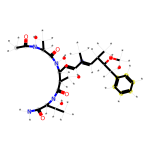

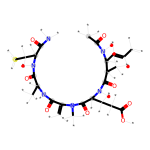

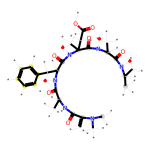

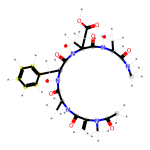

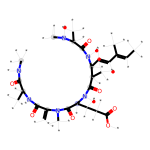

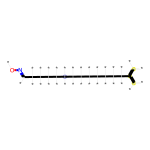

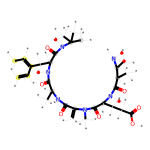

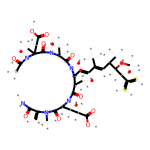

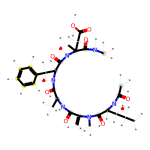

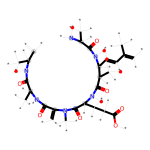

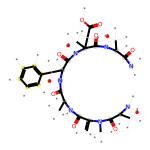

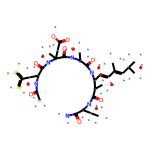

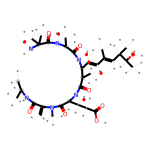

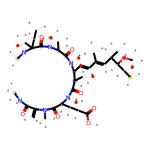

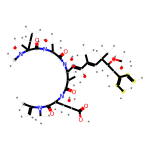

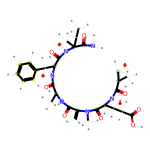

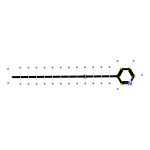

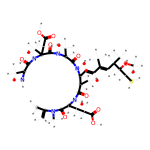

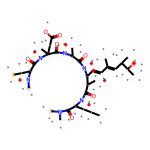

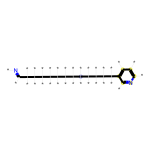

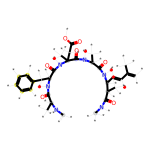

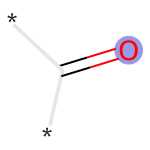

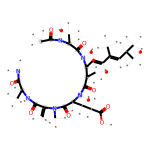

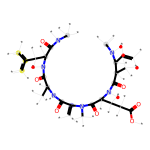

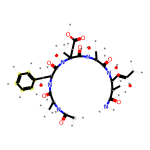

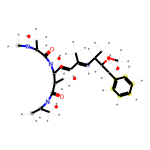

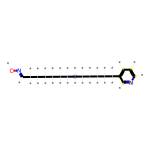

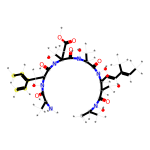

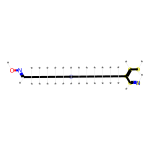

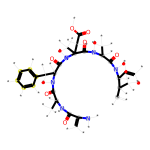

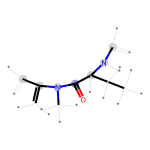

In [10]:
for bit_position in    sorted_from_position_to_num_of_mols:
    if len(bit_to_atom_groups[bit_position]): 
        mol_H,name,info = bit_to_atom_groups[bit_position][0]
        img = Draw.DrawMorganBit(mol_H,bit_position, info)   
        display(img)


In [11]:
bit_to_atom_groups[bit_position]

[]